In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets, models

In [2]:
train_data=pd.read_csv('/content/drive/MyDrive/archive/sign_mnist_train.csv')
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [3]:
labels=train_data['label']

In [4]:
text="pixel"
images=torch.zeros((train_data.shape[0],1))
for i in range(1,785):
    temp_text=text+str(i)
    temp=train_data[temp_text]
    temp=torch.FloatTensor(temp).unsqueeze(1)
    images=torch.cat((images,temp),1)
images_final=torch.FloatTensor(images[:,1:]).view(-1,28,28)

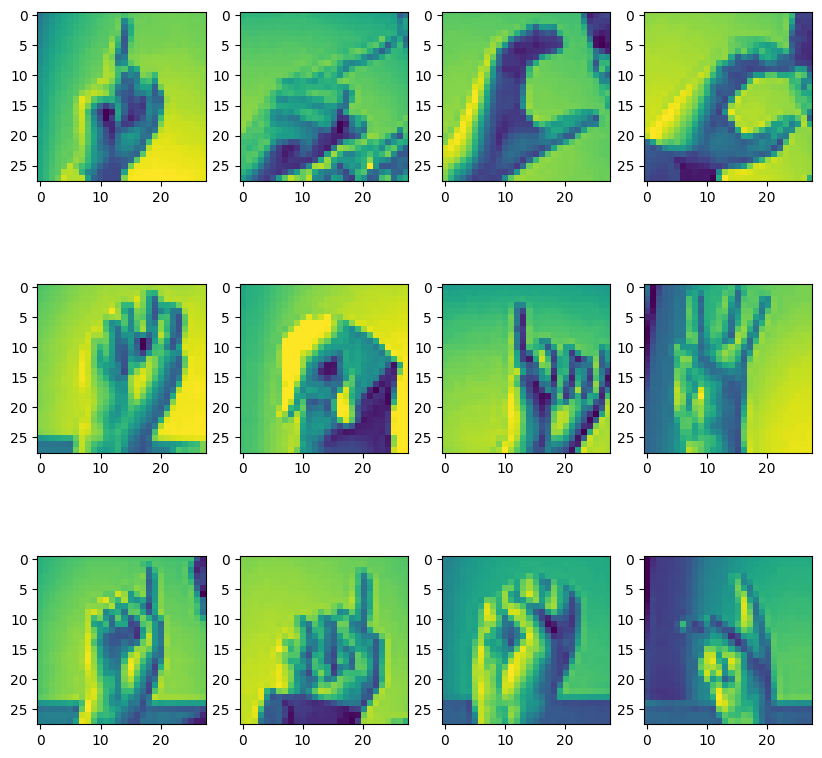

In [5]:
fig=plt.figure(figsize=(10,10))
columns=3
rows=4
for i in range(12):
    img=images_final[i,:]
    img=img.numpy()
    fig.add_subplot(columns, rows, i + 1)
    plt.imshow(img)
plt.show()

In [6]:
train_data=np.array(train_data)

In [7]:
class GestureDataset(Dataset):
    def __init__(self,csv,train=True):
        self.csv=pd.read_csv(csv)
        self.img_size=32
        self.train=train
        text="pixel"
        self.images=torch.zeros((self.csv.shape[0],1))
        for i in range(1,785):
            temp_text=text+str(i)
            temp=self.csv[temp_text]
            temp=torch.FloatTensor(temp).unsqueeze(1)
            self.images=torch.cat((self.images,temp),1)
        self.labels=self.csv['label']
        self.images=self.images[:,1:]
        self.images=self.images.view(-1,28,28)

    def __getitem__(self,index):
        img=self.images[index]
        img=img.numpy()
        img=np.resize(img, (self.img_size,self.img_size))
        tensor_image=torch.FloatTensor(img)
        tensor_image=tensor_image.unsqueeze(0)
        tensor_image/=255.
        if self.train:
            return tensor_image,self.labels[index]
        else:
            return tensor_image
    def __len__(self):
        return self.images.shape[0]

In [8]:
data=GestureDataset("/content/drive/MyDrive/archive/sign_mnist_train.csv")
data_val=GestureDataset("/content/drive/MyDrive/archive/sign_mnist_test.csv")

In [9]:
train_loader=torch.utils.data.DataLoader(dataset=data,batch_size=128, num_workers=4, shuffle=True)
val_loader=torch.utils.data.DataLoader(dataset=data_val,batch_size=64, num_workers=0, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
classes=('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y')

In [11]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(1, 32, 5, padding=2) #128, 32, 224, 224
    self.conv2=nn.Conv2d(32, 64, 5, padding=2) #128, 64, 224, 224
    self.conv3=nn.Conv2d(64, 128, 5, padding=2) #128, 128, 224, 224
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(128 * 8 * 8, 512)
    self.fc2 = nn.Linear(512, 150)
    self.fc3 = nn.Linear(150, 25)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net=ConvNet()

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [13]:
num_epochs=2

In [ ]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.320


In [ ]:
PATH = './sgnlng_mnist_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
net = ConvNet()
net.load_state_dict(torch.load(PATH))

In [ ]:
outputs=net(images)

In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy {100 * correct // total} %')

Accuracy 35 %
